In [9]:
#=
Simulation of inverted pendulum controlled by MPC.
Controller is designed based on the linearized model, and simulation is done with the nonlinear model
=#

In [10]:
using BlockArrays;
using DifferentialEquations;
using JuMP;
using LinearAlgebra;
using Plots;

using Pkg;
Pkg.add("Ipopt");
import Ipopt;

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [11]:
#= Parameters used in simulation:
mass of cart
mass of pendulum
acceleration due to gravity
length of pendulum
Time step
=#

mutable struct Params
    mc::Float64
    mp::Float64
    g::Float64
    l::Float64
    dt::Float64
    function Params()
        return new(10., 1., 10., 2., 0.05)
    end
end

In [12]:
#= Nonlinear and linearized models of continuous time model of inverted pendulum.

ẋ_1 = x_2
ẋ_2 = [-m_p*g*sin(x_3)*cos(x_3) + m_p*l*sin(x_3)*x_4^2 + u] / [m_c + m_p - m_p*sin(x_3)^2]
ẋ_3 = x_4
ẋ_4 = [-g*(m_c + m_p)*sin(x_3) + m_p*l*sin(x_3)*cos(x_3)*x_4^2 + u*cos(x_3)] / [-l*(m_c + m_p) + m_p*l*cos(x_3)^2]

Where:
x_1 = Cart position
x_2 = Cart Velocity
x_3 = Pendulum angle
x_4 = Pendulum angular velocity

=#

function xdot(x::Vector{Float64}, params::Params, u::Float64)
    return [
        x[2],
        (-params.mp * params.g * sin(x[3]) * cos(x[3]) + params.mp * params.l * sin(x[3]) * x[4] ^ 2 + u) / 
        (params.mc + params.mp - params.mp * sin(x[3])^2),
        x[4],
        (-params.g * (params.mc + params.mp) * sin(x[3]) + params.mp * params.l * sin(x[3]) * cos(x[3]) * x[4] ^ 2 + u * cos(x[3])) / 
        (-params.l * (params.mc + params.mp) + params.mp * params.l * cos(x[3]) ^ 2)
    ]
end

function xdot_linear(x::Vector{Float64}, params::Params, u::Float64)
    A = [
        0 1 0 0;
        0 0 (params.mp * params.g / params.mc) 0;
        0 0 0 1;
        0 0 (params.g * (params.mc + params.mp) / params.mc / params.l) 0
    ]

    B = [0; 1 / params.mc; 0; -1 / params.mc / params.l]
    
    return A*x + B*u
end

xdot_linear (generic function with 1 method)

In [13]:
#= Discretize the above models using a simple forward Euler method, i.e.

ẋ(t) = f(x(t), u(t)) --> x(t+dt) ≈ x(t) + dtf(x(t), u(t))

=#

function xdot_discrete(x::Vector{Float64}, params::Params, u::Float64)
    return x + params.dt*xdot(x, params, u)
end

function xdot_linear_discrete(x::Vector{Float64}, params::Params, u::Float64)
    return x + params.dt*xdot_linear(x, params, u)
end

xdot_linear_discrete (generic function with 1 method)

In [14]:
# Define the MPC controller

function mpc(x, A, B)
    #=
    Basic MPC for regulation without constraints, solves:
    minimize    Σ(x^TQx + x^TRx) + x^TPx
    subject to  x(k+1) = Ax(k) + Bu(k)
    =#

    # Control Parameters
    n = 72;                                         # Control/prediction horizon
    q = 100*Diagonal([1 for i in 1:size(x)[1]])     # Weight on the states
    r = 5*Diagonal([1 for i in 1:1])                # Weight on the input
    p = 10*Diagonal([1 for i in 1:size(x)[1]])     # Terminal cost

    # Form system matrices for extended state space, X = Tx(k) + ΘU, where X = (x(k+1),...,x(k+n)), U = (u(k),...,u(k+N-1))
    Θrowdims = [size(B)[1] for i in 1:n];
    Θcoldims = [1 for i in 1:n];
    Θ = BlockArray{Float32}(undef, Θrowdims, Θcoldims);
    for i in 1:n
        for j in 1:n
            if j > i
                Θ[Block(i, j)] = zeros(size(B))
            elseif i == j
                Θ[Block(i, j)] = B
            else
                Θ[Block(i, j)] = A^(i-j)*B
            end
        end
    end

    Trowdims = [size(A)[1] for i in 1:n]
    T = BlockArray{Float32}(undef, Trowdims, [size(A)[2]])
    for i in 1:n
        T[Block(i,1)] = A^i
    end

    # Form weighting matrices in the extended state space
    eye = Diagonal([1 for i in 1:n])
    Q = kron(eye,q)
    R = kron(eye,r)
    Pblocksize = [size(x)[1] for i in 1:n]
    P = BlockArray{Float32}(zeros(size(x)[1]*n,size(x)[1]*n), Pblocksize, Pblocksize)
    P[Block(n,n)] = p

    # Solve the optimization problem with JuMP
    quadterm = Matrix{Float64}(0.5*((Θ'*(Q+P)*Θ + R) + (Θ'*(Q+P)*Θ + R)'))
    temp = Matrix{Float64}(Q+P)
    linearterm = (2*x'*T'*(temp)*Θ)

    mpc = JuMP.Model()
    set_optimizer(mpc, Ipopt.Optimizer)
    set_silent(mpc)
    @variable(mpc, U[1:size(B)[2]*n])
    
    # Box Constraints on the input
    #@constraint(mpc, constraint1, U .<= 125)
    #@constraint(mpc, constraint2, U .>= -125)
    
    @objective(mpc, Min, U'*quadterm*U + linearterm*U)
    optimize!(mpc)
    
    u = value.(U)[1];          # MPC control action is the first of the input sequences

    return u
end;

In [15]:
# Iterate through time steps to simulate the process under control 

params = Params()
t = 0:params.dt:25
x = [[0., 0., 0., 0.]] #Initial conditions of pendulum
u = [0.]
A = I + params.dt*[
    0 1 0 0;
    0 0 (params.mp * params.g / params.mc) 0;
    0 0 0 1;
    0 0 (params.g * (params.mc + params.mp) / params.mc / params.l) 0
]

B = params.dt*[0; 1 / params.mc; 0; -1 / params.mc / params.l]
B = reshape(B, (4,1)) # use reshape() to change the type from Vector{Float64} to Matrix{Float64} required by mpc()

for i in t[2:end]
    push!(u, mpc(last(x), A, B))
    # Uncomment to simulate with linearized model rather than the nonlinear model
    #push!(x, xdot_linear_discrete(last(x), params, last(u)))
    push!(x, xdot_discrete(last(x), params, last(u)))
    if i == 1.0
        last(x)[4] = -2 # Instantaneous change in angular velocity, simulating flicking the ball
    end
end

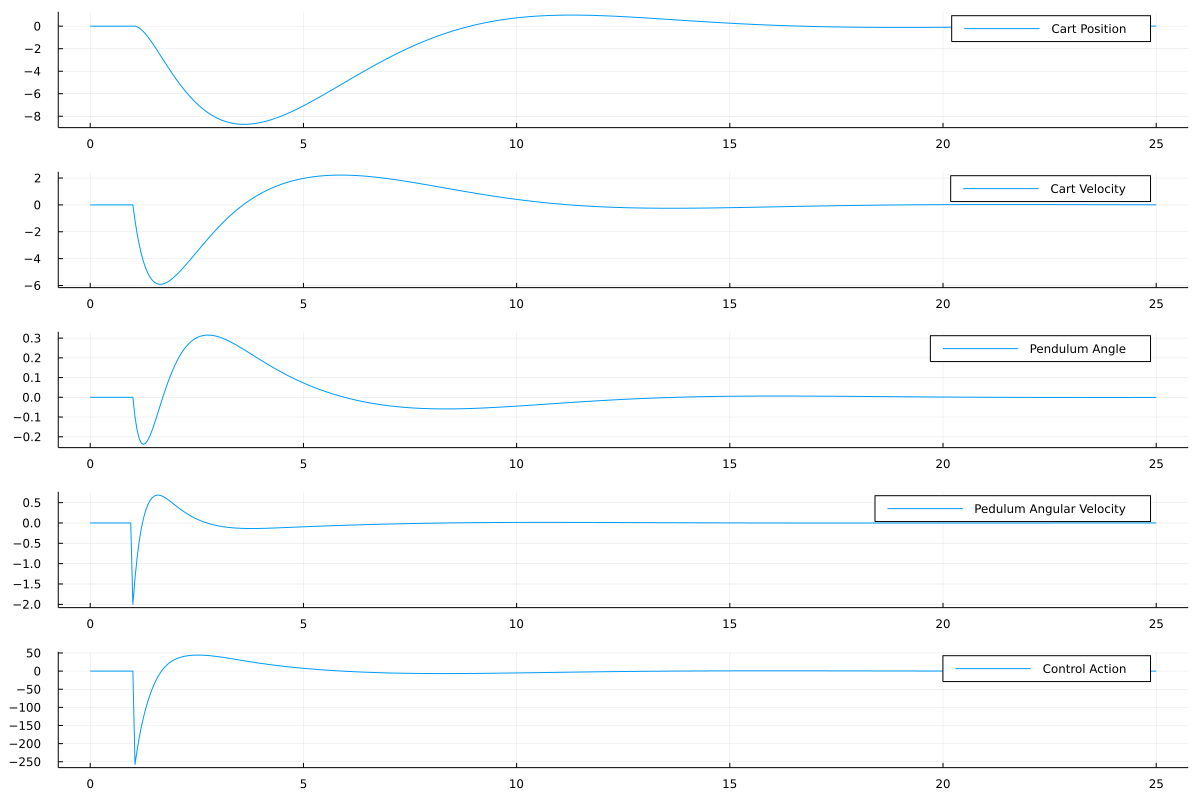

In [16]:
# Plot the results

x1 = []
x2 = []
x3 = []
x4 = []
for i in 1:size(x)[1]
    push!(x1, x[i][1])
    push!(x2, x[i][2])
    push!(x3, x[i][3])
    push!(x4, x[i][4])
end

p1 = plot(t, x1, label = "Cart Position")
p2 = plot(t, x2, label = "Cart Velocity")
p3 = plot(t, x3, label = "Pendulum Angle")
p4 = plot(t, x4, label = "Pedulum Angular Velocity")
p5 = plot(t, u, label = "Control Action")

plot(p1, p2, p3, p4, p5, layout = (5,1), size = (1200, 800))

In [17]:
# Animate the simulation

#ENV["GKSwstype"]="nul" # Call this if using WSL

anim = @animate for i in 1:length(t)
    plot([x[i][1], x[i][1] + params.l * sin(x[i][3])], 
        [0, params.l * cos(x[i][3])], 
        leg = false, 
        xlims = (-10, 1), 
        ylims = (-1, 2.5), 
        aspect_ratio = 1)
    scatter!([x[i][1]], [0], m = (:rect, 12))
    scatter!([x[i][1] + params.l * sin(x[i][3])], [params.l * cos(x[i][3])], m = (:circle, 8))
end;
gif(anim, "Inverted_pendulum.gif", fps = 20);

┌ Info: Saved animation to 
│   fn = /home/jovyan/Inverted_pendulum.gif
└ @ Plots /home/jovyan/.julia/packages/Plots/lW9ll/src/animation.jl:137
